In [8]:
import numpy as np
import random
import optuna
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score
import json
import os
from optuna.visualization import plot_optimization_history

In [9]:
SEED = 1234
 # Se puede cambiar a "precision" o "recall" o "f1-score"
SCORE = "f1-score"

In [10]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)

In [11]:
def trend_changes_score(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(y_df["is_changed_trend_test"][:-1], y_df["is_changed_trend_predict"][:-1], digits=4)

def trend_changes_true(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    report = classification_report(
        y_df["is_changed_trend_test"][:-1],
        y_df["is_changed_trend_predict"][:-1],
        output_dict=True,
        zero_division=0
    )
    return report["True"][SCORE]

In [12]:
# Cargar datos
train = pd.read_csv("../../../data/training_set.csv", parse_dates=["date"])
val = pd.read_csv("../../../data/validation_set.csv", parse_dates=["date"])
test_set = pd.read_csv("../../../data/test_set.csv", parse_dates=['date'])
X_train = train.drop(columns=["date", "target_trend"]).values
y_train = train["target_trend"].values
X_val = val.drop(columns=["date", "target_trend"]).values
y_val = val["target_trend"].values
X_test = test_set.drop(columns=['target_trend','date']).values
y_test = test_set['target_trend'].values

In [13]:
def objective(trial):
    set_seeds(SEED)  # Fijar semilla antes de cada trial
    n_estimators = trial.suggest_int("n_estimators", 50, 400)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=SEED
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    score = trend_changes_true(y_val, y_pred)
    return score

In [14]:
set_seeds(SEED)
study = optuna.create_study(
    direction="maximize", 
    sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=100)

[I 2025-08-21 09:54:40,817] A new study created in memory with name: no-name-ff639504-5f1e-41f7-938e-43f63abc6c77
[I 2025-08-21 09:54:41,140] Trial 0 finished with value: 0.16666666666666666 and parameters: {'n_estimators': 117, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.16666666666666666.
[I 2025-08-21 09:54:41,461] Trial 1 finished with value: 0.1111111111111111 and parameters: {'n_estimators': 147, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.16666666666666666.
[I 2025-08-21 09:54:42,107] Trial 2 finished with value: 0.3157894736842105 and parameters: {'n_estimators': 289, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.3157894736842105.
[I 2025-08-21 09:54:42,755] Trial 3 finished with value: 0.17142857142857143 and parameters: {'n_estimators': 321, 'max_depth': 1

In [15]:
# Visualizar el historial de optimización
plot_optimization_history(study)

In [16]:
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor score de {SCORE}: {study.best_value:.4f}")

Mejores hiperparámetros encontrados:
{'n_estimators': 189, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}
Mejor score de f1-score: 0.4500


GUARDAR EN JSON

In [17]:
# Guardar los mejores hiperparámetros y su valor
history = []
if os.path.exists("best_hyperparams.json"):
    try:
        with open("best_hyperparams.json", "r") as f:
            history = json.load(f)
    except (json.JSONDecodeError, ValueError):
        history = []

# Guardar ambos en un solo diccionario
history.append({
    "params": study.best_params,
    "value": study.best_value
})

with open("best_hyperparams.json", "w") as f:
    json.dump(history, f, indent=2)

CARGAR HIPERPARAMETROS DESDE JSON

In [18]:
# Cargar historial de hiperparámetros y valores
with open("best_hyperparams.json", "r") as f:
    history = json.load(f)

# Escoger el último (más reciente)
best_params = history[-1]["params"]
best_value = history[-1]["value"]

# Si quieres ver todos:
for i, entry in enumerate(history):
    print(f"Hiperparámetros #{i+1}: {entry['params']}, Valor: {entry['value']}")

# Si quieres escoger uno específico (por índice):
# best_params = history[indice_que_quieras]["params"]
# best_value = history[indice_que_quieras]["value"]

Hiperparámetros #1: {'n_estimators': 189, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}, Valor: 0.45


In [23]:
# Entrenar modelo final con los mejores hiperparámetros
set_seeds(SEED)
best_params = study.best_params
final_model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    random_state=SEED
)
final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_val)
print("RandomForest FINAL trend_changes_score:\n", trend_changes_score(y_val, y_pred_final))

RandomForest FINAL trend_changes_score:
               precision    recall  f1-score   support

       False     0.9245    0.8750    0.8991       112
        True     0.3913    0.5294    0.4500        17

    accuracy                         0.8295       129
   macro avg     0.6579    0.7022    0.6745       129
weighted avg     0.8543    0.8295    0.8399       129



In [26]:
# Reporte completo: precisión, recall y F1 por clase
report = classification_report(y_val, y_pred_final, digits=4)
print("LightGBM Report:\n", report)
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_pred_final))

LightGBM Report:
               precision    recall  f1-score   support

          -1     0.7586    0.9167    0.8302        24
           0     0.3333    0.4444    0.3810        18
           1     0.9351    0.8182    0.8727        88

    accuracy                         0.7846       130
   macro avg     0.6757    0.7264    0.6946       130
weighted avg     0.8192    0.7846    0.7968       130

Balanced accuracy: 0.7264309764309765


In [24]:
# Obtener predicciones
y_pred = final_model.predict(X_test)
print("Trend Change F1 Score:\n", trend_changes_score(y_test, y_pred))

Trend Change F1 Score:
               precision    recall  f1-score   support

       False     0.9099    0.8487    0.8783       119
        True     0.0526    0.0909    0.0667        11

    accuracy                         0.7846       130
   macro avg     0.4813    0.4698    0.4725       130
weighted avg     0.8374    0.7846    0.8096       130



In [21]:
import time

import numpy as np

start_time = time.time()
importances = final_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in final_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.033 seconds


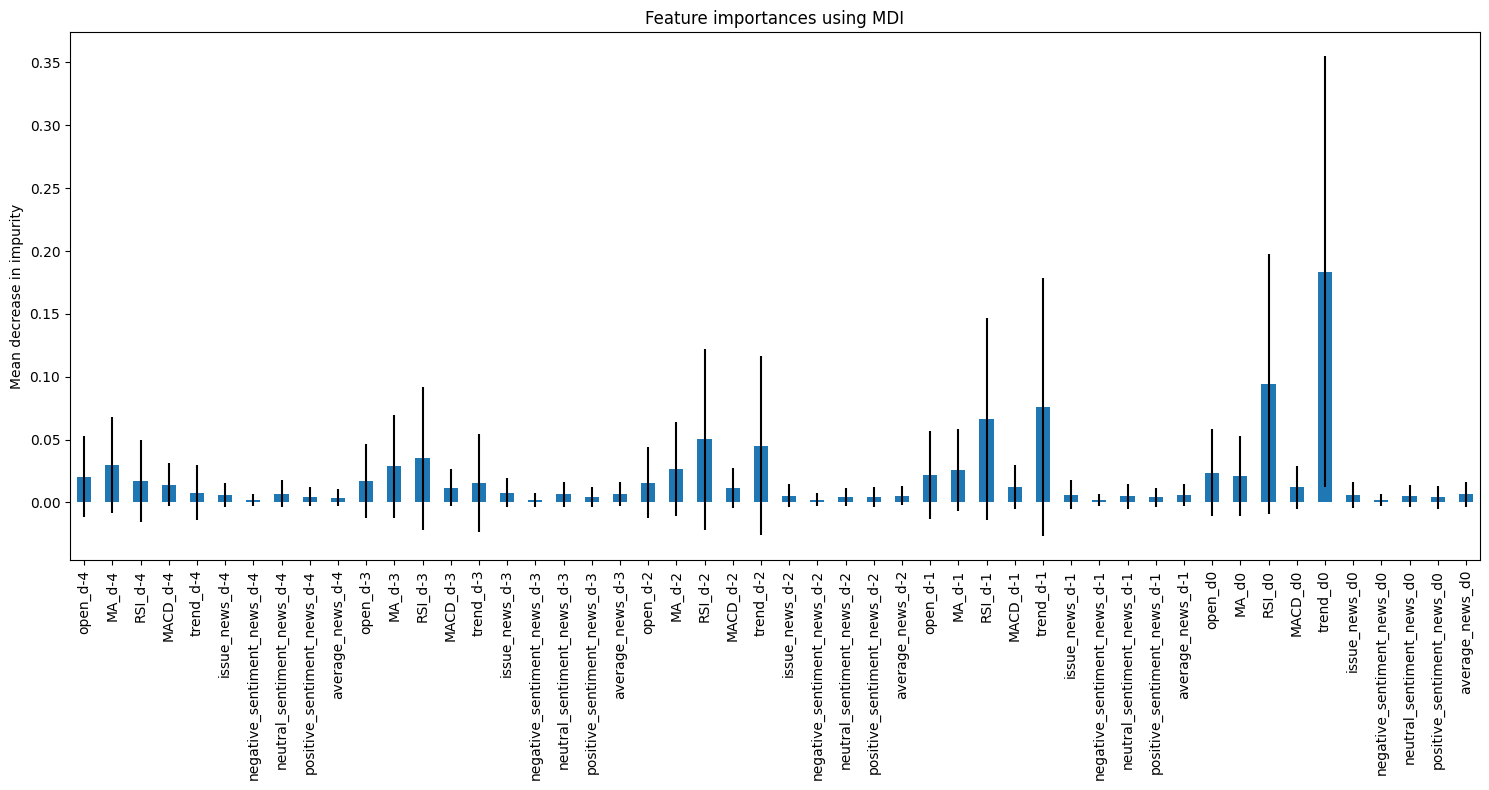

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=train.drop(columns=["date", "target_trend"]).columns)

fig, ax = plt.subplots(figsize=(15, 8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()